# Nonlinear beam model in finite rotations

In this numerical tour, we show how to formulate and solve a 3D nonlinear beam model in large displacements and  rotations. We however consider here slender structures for which local strains will remain small. We therefore adopt an infinitesimal strain linear elastic model. The main difficulty here is related to the fact that finite rotations cannot be described using a simple rotation vector as in the infinitesimal rotation case but must be handled through rotation matrices. 

This tour expands upon the work of Marco Morandini on [Finite rotation handling in Dolfin](https://home.aero.polimi.it/morandini/Downloads/DolfinFiniteRotations/html/index.html#). Contrary to this implementation which required in-depth implementations of conditional UFL expression and custom assembly procedure, we adopt a slightly different discretization strategy which alleviates the problem encountered in this previous implementation.

The following animation illustrates how an initially horizontal beam, subject to a concentrated couple and horizontal transversal force, rolls up on itself several times. Note here that self-contact is not taken into account.

![](helical_beam.gif)

## Handling finite rotations
$\newcommand{\bA}{\boldsymbol{A}}
\newcommand{\bR}{\boldsymbol{R}}
\newcommand{\bG}{\boldsymbol{G}}
\newcommand{\bH}{\boldsymbol{H}}
\newcommand{\br}{\boldsymbol{r}}
\newcommand{\ba}{\boldsymbol{a}}
\newcommand{\bb}{\boldsymbol{b}}
\newcommand{\bu}{\boldsymbol{u}}
\newcommand{\bg}{\boldsymbol{g}}
\newcommand{\be}{\boldsymbol{e}}
\newcommand{\bN}{\boldsymbol{N}}
\newcommand{\bP}{\boldsymbol{P}}
\newcommand{\bM}{\boldsymbol{M}}
\newcommand{\bC}{\boldsymbol{C}}
\newcommand{\bR}{\boldsymbol{R}}
\newcommand{\bI}{\boldsymbol{I}}
\newcommand{\T}{^\text{T}}
\newcommand{\btheta}{\boldsymbol{\theta}}
\newcommand{\bvartheta}{\boldsymbol{\vartheta}}
\newcommand{\bXi}{\boldsymbol{\Xi}}
\newcommand{\bTheta}{\boldsymbol{\Theta}}
\newcommand{\bepsilon}{\boldsymbol{\epsilon}}
\newcommand{\bchi}{\boldsymbol{\chi}}
\newcommand{\bOmega}{\boldsymbol{\Omega}}
\newcommand{\bomega}{\boldsymbol{\omega}}
\newcommand{\axial}{\operatorname{axial}}
\renewcommand{\skew}{\operatorname{skew}}
\newcommand{\dx}{\,\text{dx}}$

### Choosing a parametrization

Handling finite rotations is a difficult point in a finite-element context as these should be described through rotation matrices $\bR$ belonging to the special orthogonal group $SO(3)$ i.e. such that $\bR\T\bR=\bI$ and $\det\bR=1$. It is however not possible to easily interpolate elements of this group using standard finite-element techniques. Various approaches therefore attempt to parametrize elements of this group such as:

 * vectorial parametrizations

 * Euler-angle parametrizations

 * quaternion parametrizations

 * cosine direction parametrizations...

In all of these methods, a rotation matrix is parametrized by a finite set of parameters: e.g. 3 for vectorial and Euler angle parametrizations, 4 for quaternion parametrizations, 9 for cosine direction, etc. Each of these methods will have some sort of singularity in the parametrization as the mapping can never be bijective. As a result, all methods possess some advantages and some drawbacks, either on the theoretical or computational point of view.

In this tour, we make use of vectorial parametrizations which have the advantage of being based on a parameter, namely the rotation vector $\btheta$, which behaves as a Cartesian 3D vector. We refer to [[BAU03]](#References) for an excellent and unified presentation of the vectorial parametrization. Implementation is described in the following document [A module for rotation parametrization](rotation_parametrization_description.ipynb)



### A reminder on rotation matrices

A rotation can be described by a unit rotation axis $\bu$ and a rotation angle $\varphi$, thus defining a rotation vector $\btheta=\varphi\bu$. The link with the rotation matrix $\bR$ is given by the well-known Euler-Rodrigues formula:
\begin{equation}
\bR = \bI + \dfrac{\sin\varphi}{\varphi}\bP + \left(\dfrac{\sin(\varphi/2)}{\varphi/2}\right)^2\bP^2
\end{equation}
with $\bP = \skew(\btheta)$ where $\skew$ defines the skew-symmetric matrix associated with the cross-product operation of a vector, that is:
\begin{align}
\skew(\ba)\bb &= \ba \times \bb \quad \forall \bb \\
\skew(\ba) &= \begin{bmatrix} 0 & -a_3 & a_2\\ a_3 & 0 & -a_1 \\ -a_2 & a_1 & 0 \end{bmatrix}
\end{align}

We also introduce $\axial(\bA)=\ba$ the inverse operation associated to a skew-symmetric matrix $\bA$ the corresponding vector $\ba$ such that $\bA=\skew(\ba)$. We also have that $\axial(\bR\bA\bR\T)=\bR\ba$ when $\bR$ is a rotation matrix.

For any rotation matrix $\bR$, we have $\dot{\overline{\bR\T\bR}} = \dot\bR\T\bR +  \bR\T\dot\bR=0$ from which we deduce that $\bTheta=\bR\T\dot\bR$ is skew-symmetric. We denote by $\bvartheta = \axial(\Theta)$ the so-called spatial spin vector associated with the rotation matrix. The link between the spin vector and the time derivative of the rotation vector is given by the rotation curvature matrix $\bH$:
\begin{equation}
\bvartheta = \bH\T\dot\btheta
\end{equation}

### The small rotation case
For small rotations i.e. $\|\btheta\|=\varphi \ll 1$, we have $\bR \approx \bI + \bP$. As a result:

\begin{equation}
\dot\bR = \dot\bP = \bR\T\bTheta
\end{equation}

we have, at first order, $\bTheta \approx \dot\bP$ and thus $\bvartheta \approx \dot\btheta$ and $\bH\approx\bI$.
 

## Nonlinear beam model formulation
### Beam kinematics and strain measures

Following the notations from [[MAS20]](#References), we consider a nonlinear Timoshenko beam model which is described by the position  $\br_0(s)$ of the beam axis in the reference undeformed configuration $\mathcal{L}_0$ where $s$ is the beam curvilinear coordinate. The reference configuration $\mathcal{L}_0$ is also described by a triad of unit material vectors $\bG_i(s)$ representing the beam axis $\bG_1$ and the cross-section principal axis $\bG_2,\bG_3$. Note that $\bG_1$ is equal to the unit tangent vector:
\begin{equation}
\bG_1(s)=\dfrac{d\br_0}{ds}(s)
\end{equation}
The material vectors triad can be equivalently described by a rotation matrix $\bR_0(s)$ which sends the initial cartesian frame $\be_i$ to the material triad $\bG_i(s)$ i.e. 
\begin{equation}
\bR_0(s) = \bG_i(s)\otimes \be_i
\end{equation}

In a similar manner, we define the current position and material triad in the deformed configuration as follows:
\begin{align}
\br(s) &= \br_0(s)+\bu(s) \\
\bg_i(s) &= \bR(s)\bG_i(s)
\end{align}
where $\bu(s)$ is the beam axis displacement and $\bR(s)$ the rotation matrix.

As we restrict to a finite rotation/small strain setting, the beam strain measures are given by:
* a translational strain measure:
\begin{equation}
\bepsilon =\bR\T(\bu_{,s}+\bG_1) - \bG_1
\end{equation}
* a rotational strain measure:
\begin{equation}
\bchi = \axial( \bR\T\bR_{,s}) 
\end{equation}
Their components along the material triad $\bG_i$ respectively give the axial strain $\epsilon = \bepsilon\T\bG_1$, the shear strains $\gamma_2 = \bepsilon\T\bG_2$, $\gamma_3 = \bepsilon\T\bG_3$, the torsional strain $\kappa = \bchi\T\bG_1$ and the bending strains $\chi_2 = \bchi\T\bG_2$, $\chi_3 = \bchi\T\bG_3$.

> Note that in the case of small rotations $\bR \approx \bI + \bP$ so that, at first order:
\begin{align}
\bepsilon \approx \bu_{,s}+\bP\T\bG_1 = \bu_{,s} - \btheta \times \bG_1 =  \begin{Bmatrix}  u_{1,s} \\ u_{2,s} - \theta_3 \\ u_{3, s} + \theta_2 \end{Bmatrix}
\end{align}
Similarly for the rotational measure, $\bR\T\bR_{,s} \approx \bP_{,s}$ and thus
\begin{equation}
\bchi \approx \btheta_{,s}
\end{equation}
as expected.

### Stress measures and elastic constitutive relation

The above strain measures define the corresponding stress measures $\bN$ and $\bM$ corresponding to axial forces and twist/bending moments. We adopt in the following a simple elastic constitutive law (without coupling) such that:
\begin{align}
\bN &= \bC_N\bepsilon = \begin{bmatrix} ES & 0 & 0 \\ 0 & \mu S_2^* & 0 \\ 0 & 0 & \mu S_3^* \end{bmatrix}\bepsilon \\
\bM &= \bC_M\bchi = \begin{bmatrix} \mu J & 0 & 0 \\ 0 & EI_2 & 0 \\ 0 & 0 & EI_3 \end{bmatrix}\bchi 
\end{align}
where $S$ is the beam cross-section, $E,\mu$ the Young and shear moduli, $S_2^*,S_3^*$ the reduced cross-sections accounting for shear reduction coefficients (see [this tour](https://comet-fenics.readthedocs.io/en/latest/demo/cross_section_analysis/cross_section_analysis.html)), $J$ the torsional intertia and $I_2,I_3$ the area moment of inertia.

The beam hyperelastic energy is then given by:
\begin{equation}
\mathcal{E}_\text{el} = \dfrac{1}{2}\int_{\mathcal{L}_0} (\bepsilon\T\bC_N\bepsilon + \bchi\T\bC_M\bchi) \dx
\end{equation}

### Residual form

The equilibrium solution is obtained through the resolution of the following non-linear equation:
\begin{equation}
\partial_{(\bu,\btheta)} \mathcal{E}_\text{el}(\widehat{\bu},\widehat{\btheta}) - W_\text{ext}(\widehat{\bu},\widehat{\btheta})=0 \quad \forall (\widehat{\bu},\widehat{\btheta})\in V
\end{equation}
where $W_\text{ext}$ is the work of external loads in the virtual fields $(\widehat{\bu},\widehat{\btheta})$. Under a prescribed distributed external force $\mathcal{F}$ and moment $\mathcal{M}$, it reads as:
\begin{equation}
W_\text{ext}(\widehat{\bu},\widehat{\btheta}) = \int_{\mathcal{L}} \left(\mathcal{F}\cdot \widehat{\bu}+\mathcal{M}\cdot \bH\widehat{\btheta}\right) \dx
\end{equation}

Note that the resulting bilinear tangent form will not be symmetric due to the applied moment being non-conservative.

## Incremental formulation

As mentioned previously, any rotation parametrization will encounter singularity issues for large rotation angles (e.g. $\pi$ or $2\pi$ depending on the chosen parametrization). The previous formulation will therefore be unable to solve problems in which the solution experiences rotation angles of such amplitudes. As an alternative, it is possible to solve only, for a given load step, for the incremental displacement and rotation with respect to the known equilibrium from the previous converged load step. Positions and material triad orientations must therefore be updated at the end of every load step. With such an approach, singularity issues will only encountered if the incremental rotation is too large, which is not a strong requirement in practice.

In this `incremental` approach, let us consider that $\bu$ and $\btheta$ now represent the displacement and rotation vector increments with respect to a known configuration at load step $n$. The sought configuration at load step $n+1$ is obtained from:
\begin{align}
\br_{n+1} &= \br_n+\bu \\
\bR_{n+1} &= \bR(\btheta)\bR_n
\end{align}

Regarding the strain measures, we have:

\begin{align}
\bepsilon_{n+1} &=\bR_n\T\bR(\btheta)\T(\bu_{,s}+\br_{n,s}) - \br_{n,s} \\
\bchi_{n+1} &= \axial( \bR_n\T\bR(\btheta)\T(\bR(\btheta)\bR_n)_{,s}) \\
&= \axial( \bR_n\T\bR_{n,s}) + \axial(\bR_n\T\bTheta_{,s}\bR_n) \\
&= \bchi_n + \bR_n\T\axial(\bTheta_{,s}) \\
&= \bchi_n + \bR_n\T\bH\T\btheta_{,s}
\end{align}

In the following implementation, we will store the curvature strain and the rotation matrix of the previous time step as functions defined on a suitable function space (DG-0 for instance). As discussed in [[MAS20]](#References) such kind of choice results in a path-dependent solution due to the non-linear nature of the group of rotations. Several strategies can be considered to alleviate or suppress such lack of objectivity. In the following, we chose to ignore this issue, the effects of which diminish upon load step and mesh refinement.

## Implementation

We first import the relevant module and functions. In particular, we import the `ExponentialMap` parametrization of rotations from the `rotation_parametrization.py` module. We then define the mesh of a rectilinear beam along the global X axis. We explicitly build the mesh using `meshio` data structures, write it to `.xdmf` format and load it back. Doing so we obtain a mesh of topology dimension 1 and geometrical dimension 3, instead of 1 if we were using the `IntervalMesh` built-in function. With this precaution the following implementation will be completely generic without making any a priori assumption on the geometry, for instance when defining tangent vectors etc. We also define the `left_end` and `right_end` boundary markers for applying loading and boundary conditions.

In [1]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
from ufl import diag, Jacobian, shape
from rotation_parametrization import ExponentialMap
from IPython.display import clear_output
import meshio

# Mesh
length = 10.0
N = 40 # number of elements

points = np.zeros((N+1, 3))
points[:, 0] = np.linspace(0, length, N+1)
cells = np.array([[i, i+1] for i in range(N)])
meshio.write("mesh.xdmf", meshio.Mesh(points, {"line": cells}))

mesh = Mesh()
with XDMFFile("mesh.xdmf") as infile:
    infile.read(mesh)
    
    
def left_end(x, on_boundary):
    return near(x[0], 0)
def right_end(x, on_boundary):
    return near(x[0], length)

facets = MeshFunction("size_t", mesh, 0)
AutoSubDomain(left_end).mark(facets, 1)
AutoSubDomain(right_end).mark(facets, 2)

We now define the geometric and material properties of the beam cross-section as well as the loading corresponding to those investigated in [[IBR95]](#References). The loading consists of an externally applied concentrated bending moment $\boldsymbol{m}(t)=-M_\text{max}t\be_y$ and concentrated load $\boldsymbol{f}(t)=F_\text{max} t \be_y$ applied in 400 load steps. Finally, we specify the method resolution relying either on the `total` rotation vector or on the `incremental` rotation vector.

In [2]:
# Geometrical properties
radius = Constant(0.2)
S = pi * radius ** 2
I = pi * radius ** 4 / 4

# Stiffness moduli
ES = Constant(1e4)
GS = Constant(1e4)
GS_2 = GS
GS_3 = GS
EI = Constant(1e2)
EI_2 = EI
EI_3 = EI
GJ = Constant(1e2)


# Loading parameters
M_max = Constant(100 * 2* np.pi)
F_max = Constant(50.)
Tlist = np.linspace(0, 1.0, 501)
load = Expression("t", t=0, degree=0)


# Resolution method {"total", "incremental"}
method = "incremental"

We now define a mixed function space consisting of a $P_2$ displacement vector and $P_1$ rotation parameter vector. We will also need a DG-0 function space for keeping track of the previous rotation matrix as well as the previous curvature strain for implementing the `incremental` approach. We also keep track of the total displacement vector.

In [3]:
Ue = VectorElement("CG", mesh.ufl_cell(), 2, dim=3)
Te = VectorElement("CG", mesh.ufl_cell(), 1, dim=3)
V = FunctionSpace(mesh, MixedElement([Ue, Te]))

v_ = TestFunction(V)
u_, theta_ = split(v_)
dv = TrialFunction(V)
v = Function(V, name="Generalized displacement")
u, theta = split(v)

VR = TensorFunctionSpace(mesh, "DG", 0, shape=(3, 3))
R_old = Function(VR, name="Previous rotation matrix")
R_old.interpolate(Constant(((1, 0, 0), (0, 1, 0), (0, 0, 1))))

V0 = VectorFunctionSpace(mesh, "DG", 0, dim=3)
curv_old = Function(V0, name="Previous curvature strain")


Vu = V.sub(0).collapse()
total_displ = Function(Vu, name="Previous total displacement")

We now define the rotation parametrization and the corresponding rotation and curvature matrices obtained from the vector rotation parameter $\btheta$. We then use the mesh `Jacobian` (which we flatten to be of shape=(3,)) to compute the beam axis unit tangent vector `t0` in the reference configuration. We then define the `tgrad` function in order to compute the curvilinear derivative in the beam axis direction.

In [4]:
rot_param = ExponentialMap()
R = rot_param.rotation_matrix(theta)
H = rot_param.curvature_matrix(theta)

Jac = Jacobian(mesh)
gdim = mesh.geometry().dim()
Jac = as_vector([Jac[i, 0] for i in range(gdim)])
t0 = Jac/sqrt(dot(Jac, Jac))

def tgrad(u):
    return dot(grad(u), t0)

The strain measures are now defined, depending on the chosen resolution method. We also define the constitutive matrices.

In [5]:
if method == "total":
    defo = dot(R.T, t0 + tgrad(u)) - t0
    curv = dot(H.T, tgrad(theta))
elif method == "incremental":
    R_new = R * R_old
    defo = dot(R_new.T, t0 + tgrad(total_displ + u)) - t0
    curv = curv_old + dot(R_old.T * H.T, tgrad(theta))
    
C_N = diag(as_vector([ES, GS_2, GS_3]))
C_M = diag(as_vector([GJ, EI_2, EI_3]))

We first define a uniform quadrature degree of 4 for integrating the various nonlinear forms.
We are now in position to define the beam elastic energy as well as the nonlinear residual form expressing balance between the internal and external works. The corresponding tangent form is also derived for the Newton-Raphson solver.

In [6]:
metadata = {"quadrature_degree": 4}
ds = Measure("ds", domain=mesh, subdomain_data=facets, metadata=metadata)
dx = Measure("dx", domain=mesh, metadata=metadata)

elastic_energy = 0.5 * (dot(defo, dot(C_N, defo)) + dot(curv, dot(C_M, curv))) * dx

residual = derivative(elastic_energy, v, v_)
residual += load * (M_max* dot(H, theta_)[1] - F_max * u_[1]) * ds(2)

tangent_form = derivative(residual, v, dv)

We finish by defining the clamped boundary conditions and the nonlinear newton solver.

In [7]:
bcs = DirichletBC(V, Constant((0,)*6), left_end)

problem = NonlinearVariationalProblem(residual, v, bcs, tangent_form)
solver = NonlinearVariationalSolver(problem)
prm = solver.parameters["newton_solver"]
prm["linear_solver"] = "mumps"
tol = 1e-6
prm["absolute_tolerance"] = tol
prm["relative_tolerance"] = tol

During the load stepping loop, total displacement and rotation vectors will be saved to `.xdmf` format every few increments. We also plot the trajectory of the extremal point in the $X-Z$ plane. Note that depending on the resolution method, the total displacement is given by $\bu$ for the `total` method or by incrementing it with $\bu$ for the `incremental` method. For the latter case, we also update the previous rotation matrix and curvature. Note also that for this approach, a good initial guess is the zero vector, rather than the previous increment. We therefore zero the solution vector with `v.vector().zero()` which will be used as an initial guess for the next increment.

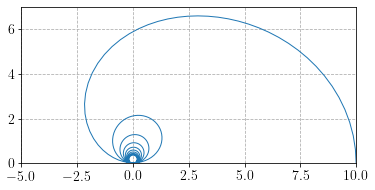

In [9]:
uh = np.zeros((len(Tlist), 3))

out_file = XDMFFile("helical_beam.xdmf")
out_file.parameters["functions_share_mesh"] = True
out_file.parameters["flush_output"] = True
for (i, t) in enumerate(Tlist[1:]):
    load.t = t

    solver.solve()
    displ = v.sub(0, True)

    if method == "total":
        total_displ.vector()[:] = displ.vector()[:]
    if method == "incremental":
        total_displ.vector()[:] += displ.vector()[:]
        R_old.assign(project(R * R_old, VR))
        curv_old.assign(project(curv, V0))
        v.vector().zero()

    uh[i+1, :] = total_displ((length, 0, 0))

    rotation_vector = v.sub(1, True)
    rotation_vector.rename("Rotation vector", "")

    if i % 10 == 0:
        out_file.write(rotation_vector, t)
        out_file.write(total_displ, t)

        clear_output(wait=True)
        plt.plot(length+uh[:i+2, 0], uh[:i+2, 2], linewidth=1)
        plt.xlim(-length/2, length)
        plt.gca().set_aspect("equal")
        plt.show()
        
out_file.close()

## References

[BAU03] Bauchau, O. A., & Trainelli, L. (2003). The vectorial parameterization of rotation. Nonlinear dynamics, 32(1), 71-92.

[IBR95] Ibrahimbegović, A., Frey, F., & Kožar, I. (1995). Computational aspects of vector‐like parametrization of three‐dimensional finite rotations. International Journal for Numerical Methods in Engineering, 38(21), 3653-3673.

[MAS20] Magisano, D., Leonetti, L., Madeo, A., & Garcea, G. (2020). A large rotation finite element analysis of 3D beams by incremental rotation vector and exact strain measure with all the desirable features. Computer Methods in Applied Mechanics and Engineering, 361, 112811.